In [2]:
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_sample_images

In [3]:
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

In [4]:
images = load_sample_images()["images"]
images = tf.keras.layers.CenterCrop(height=70, width=120)(images)
images = tf.keras.layers.Rescaling(scale=1 / 255)(images)

In [5]:
images.shape

TensorShape([2, 70, 120, 3])

In [6]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7)
fmaps = conv_layer(images)

In [7]:
fmaps.shape

TensorShape([2, 64, 114, 32])

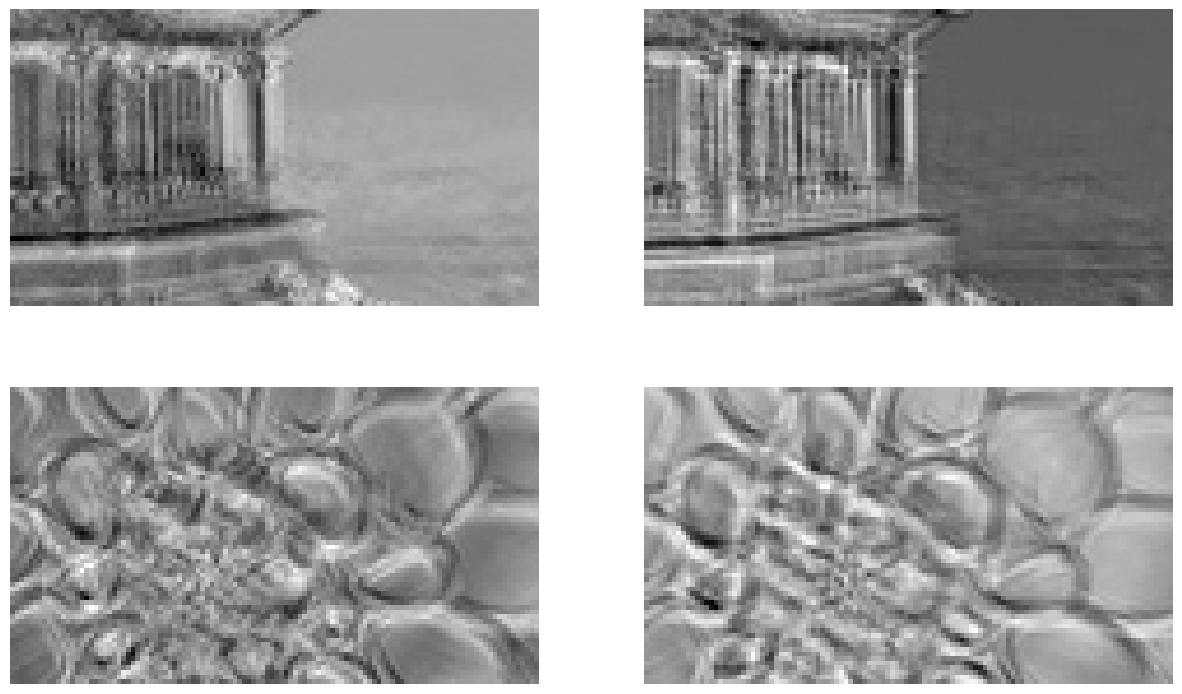

In [8]:
plt.figure(figsize=(15, 9))
for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

In [9]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7,
                                    padding="same")
fmaps = conv_layer(images)

In [10]:
fmaps.shape

TensorShape([2, 70, 120, 32])

In [11]:
conv_layer = tf.keras.layers.Conv2D(filters=32, kernel_size=7, padding="same",
                                    strides=2)
fmaps = conv_layer(images)
fmaps.shape

TensorShape([2, 35, 60, 32])

In [12]:
import numpy as np

def conv_output_size(input_size, kernel_size, strides=1, padding="valid"):
    if padding=="valid":
        z = input_size - kernel_size + strides
        output_size = z // strides
        num_ignored = z % strides
        return output_size, num_ignored
    else:
        output_size = (input_size - 1) // strides + 1
        num_padded = (output_size - 1) * strides + kernel_size - input_size
        return output_size, num_padded

conv_output_size(np.array([70, 120]), kernel_size=7, strides=2, padding="same")

(array([35, 60]), array([5, 5]))

In [13]:
kernels, biases = conv_layer.get_weights()
kernels.shape

(7, 7, 3, 32)

In [14]:
biases.shape

(32,)

In [15]:
tf.random.set_seed(42)
filters = tf.random.normal([7, 7, 3, 2])
biases = tf.zeros([2])
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

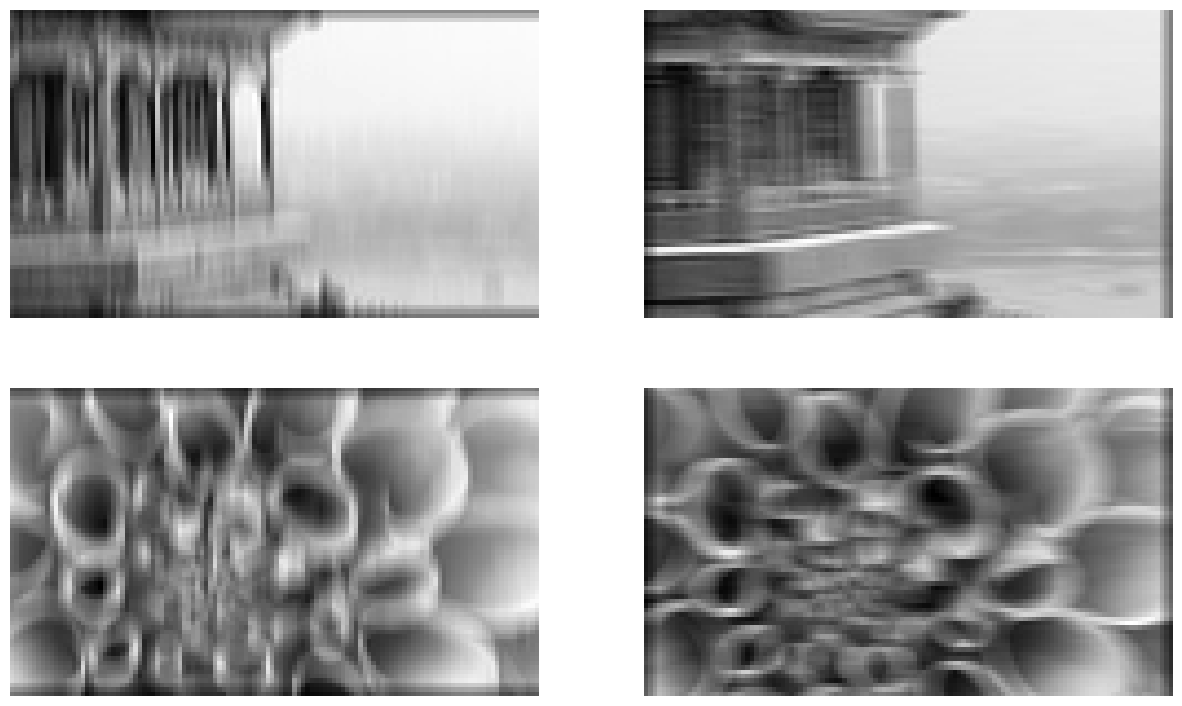

In [16]:
plt.figure(figsize=(15, 9))
filters = np.zeros([7, 7, 3, 2])
filters[:, 3, :, 0] = 1
filters[3, :, :, 1] = 1
fmaps = tf.nn.conv2d(images, filters, strides=1, padding="SAME") + biases

for image_idx in (0, 1):
    for fmap_idx in (0, 1):
        plt.subplot(2, 2, image_idx * 2 + fmap_idx + 1)
        plt.imshow(fmaps[image_idx, :, :, fmap_idx], cmap="gray")
        plt.axis("off")

plt.show()

# Poolings

In [27]:
max_pool = tf.keras.layers.MaxPool2D(pool_size=2)

In [28]:
output = max_pool(images)

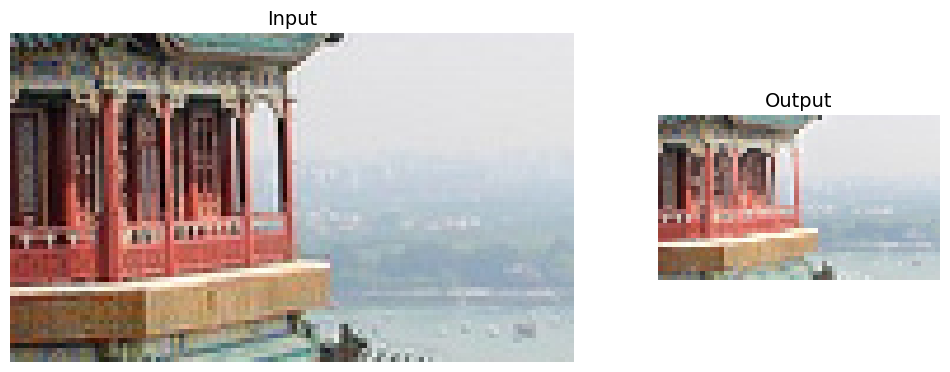

In [29]:
import matplotlib as mpl
fig = plt.figure(figsize=(12, 8))
gs = mpl.gridspec.GridSpec(nrows=1, ncols=2, width_ratios=[2, 1])

ax1 = fig.add_subplot(gs[0, 0])
ax1.set_title("Input")
ax1.imshow(images[0])  # plot the 1st image
ax1.axis("off")
ax2 = fig.add_subplot(gs[0, 1])
ax2.set_title("Output")
ax2.imshow(output[0])  # plot the output for the 1st image
ax2.axis("off")
plt.show()

In [30]:
np.random.seed(42)
fmaps = np.random.rand(2, 70, 120, 60)
with tf.device("/cpu:0"):
    output = tf.nn.max_pool(fmaps, ksize=(1, 1, 1, 3), strides=(1, 1, 1, 3),
                            padding="VALID")
output.shape

TensorShape([2, 70, 120, 20])

In [32]:
class DepthPool(tf.keras.layers.Layer):
    def __init__(self, pool_size=2, **kwargs):
        super().__init__(**kwargs)
        self.pool_size = pool_size
    
    def call(self, inputs):
        shape = tf.shape(inputs)  # shape[-1] is the number of channels
        groups = shape[-1] // self.pool_size  # number of channel groups
        new_shape = tf.concat([shape[:-1], [groups, self.pool_size]], axis=0)
        return tf.reduce_max(tf.reshape(inputs, new_shape), axis=-1)

In [33]:
np.allclose(DepthPool(pool_size=3)(fmaps), output)

True

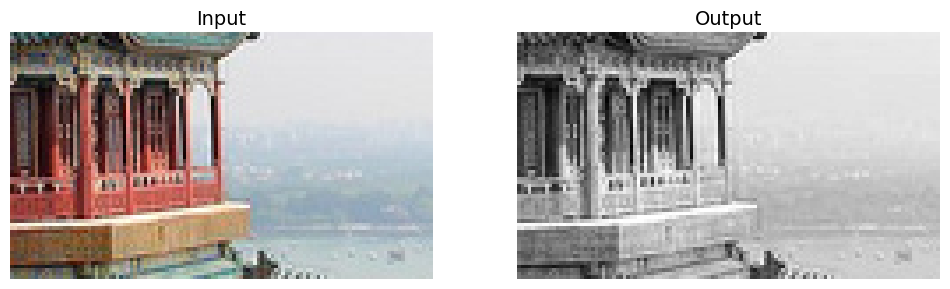

In [34]:
depth_output = DepthPool(pool_size=3)(images)

plt.figure(figsize=(12, 8))
plt.subplot(1, 2, 1)
plt.title("Input")
plt.imshow(images[0])  # plot the 1st image
plt.axis("off")
plt.subplot(1, 2, 2)
plt.title("Output")
plt.imshow(depth_output[0, ..., 0], cmap="gray")  # plot 1st image's output
plt.axis("off")
plt.show()

## Global Average Pooling

In [35]:
global_avg_pool = tf.keras.layers.GlobalAvgPool2D()

In [36]:
global_avg_pool = tf.keras.layers.Lambda(
    lambda X: tf.reduce_mean(X, axis=[1, 2]))

In [37]:
global_avg_pool(images)

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.64338624, 0.5971759 , 0.5824972 ],
       [0.76306933, 0.2601113 , 0.10849128]], dtype=float32)>

# CNN Architecture

In [38]:
mnist = tf.keras.datasets.fashion_mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = mnist
X_train_full = np.expand_dims(X_train_full, axis=-1).astype(np.float32) / 255
X_test = np.expand_dims(X_test.astype(np.float32), axis=-1) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

In [39]:
from functools import partial

tf.random.set_seed(42)
DefaultConv2D = partial(tf.keras.layers.Conv2D, kernel_size=3, padding="same",
                        activation="relu", kernel_initializer="he_normal")

model = tf.keras.Sequential([
    DefaultConv2D(filters=64, kernel_size=7, input_shape=[28, 28, 1]),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=128),
    DefaultConv2D(filters=128),
    tf.keras.layers.MaxPool2D(),
    DefaultConv2D(filters=256),
    DefaultConv2D(filters=256),
    tf.keras.layers.MaxPool2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=128, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=64, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(units=10, activation="softmax")
])

d:\anaconda\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [40]:
# extra code – compiles, fits, evaluates, and uses the model to make predictions
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid))
score = model.evaluate(X_test, y_test)
X_new = X_test[:10]  # pretend we have new images
y_pred = model.predict(X_new)

Epoch 1/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 111s 63ms/step - accuracy: 0.7458 - loss: 0.7341 - val_accuracy: 0.8718 - val_loss: 0.3607
Epoch 2/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 114s 66ms/step - accuracy: 0.8594 - loss: 0.4195 - val_accuracy: 0.8820 - val_loss: 0.3177
Epoch 3/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 125s 73ms/step - accuracy: 0.8844 - loss: 0.3485 - val_accuracy: 0.8982 - val_loss: 0.2881
Epoch 4/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 117s 68ms/step - accuracy: 0.8960 - loss: 0.3091 - val_accuracy: 0.9082 - val_loss: 0.2656
Epoch 5/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 117s 68ms/step - accuracy: 0.9035 - loss: 0.2846 - val_accuracy: 0.9098 - val_loss: 0.2619
Epoch 6/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 114s 66ms/step - accuracy: 0.9096 - loss: 0.2670 - val_accuracy: 0.9064 - val_loss: 0.2839
Epoch 7/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 115s 67ms/step - accuracy: 0.9164 - loss: 0.2437 - val_accuracy: 0.9074 - val_loss: 0.2672
Epoch 8/10
1719/1719 ━━━━━━━━━━━━━━━━━━━━ 116s 67ms/step - accuracy: 

# Reused Pretrained - ResNet50

In [41]:
model = tf.keras.applications.ResNet50(weights="imagenet")

102967424/102967424 ━━━━━━━━━━━━━━━━━━━━ 40s 0us/step


In [42]:
K = tf.keras.backend
images = K.constant(load_sample_images()["images"])
images_resized = tf.keras.layers.Resizing(height=224, width=224,
                                          crop_to_aspect_ratio=True)(images)

In [43]:
inputs = tf.keras.applications.resnet50.preprocess_input(images_resized)

In [44]:
Y_proba = model.predict(inputs)
Y_proba.shape

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


(2, 1000)

In [45]:
top_K = tf.keras.applications.resnet50.decode_predictions(Y_proba, top=3)
for image_index in range(len(images)):
    print(f"Image #{image_index}")
    for class_id, name, y_proba in top_K[image_index]:
        print(f"  {class_id} - {name:12s} {y_proba:.2%}")

35363/35363 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
Image #0
  n03877845 - palace       54.69%
  n03781244 - monastery    24.71%
  n02825657 - bell_cote    18.55%
Image #1
  n04522168 - vase         32.67%
  n11939491 - daisy        17.82%
  n03530642 - honeycomb    12.04%


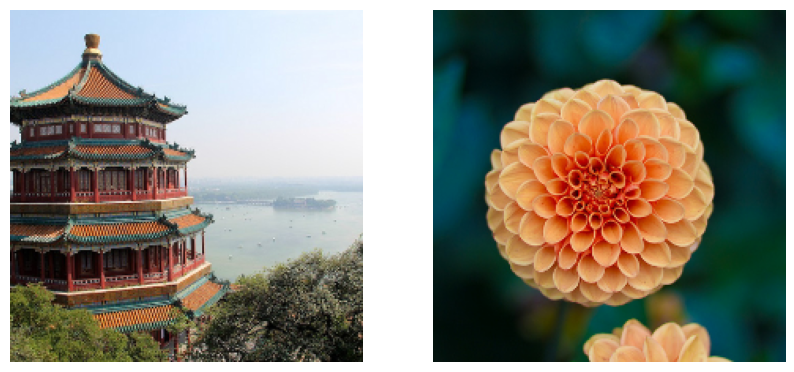

In [46]:
plt.figure(figsize=(10, 6))
for idx in (0, 1):
    plt.subplot(1, 2, idx + 1)
    plt.imshow(images_resized[idx] / 255)
    plt.axis("off")

plt.show()

# Pretrained Models for Transfer Learning

In [48]:
!pip install tensorflow_datasets

  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
   ---------------------------------------- 0.0/5.3 MB ? eta -:--:--
   ----- ---------------------------------- 0.8/5.3 MB 5.6 MB/s eta 0:00:01
   ----------------- ---------------------- 2.4/5.3 MB 7.1 MB/s eta 0:00:01
   ------------------------- -------------- 3.4/5.3 MB 6.1 MB/s eta 0:00:01
   ------------------------------------- -- 5.0/5.3 MB 6.3 MB/s eta 0:00:01
   ---------------------------------------- 5.3/5.3 MB 6.2 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21545 sha256=84d56602a23d95be15e535abe2df37182ae87661e8dcbcbbf44fcc17a650f3ea
  Stored in directory: c:\users\msi gl65\appdata\local\pip\cache\wheels\8f\46\1c\1f4e5d73a20eb816ead5014e97cdeb3928cf314fc46c7bab61
Successfully built promise

   ---------------------------------------- 0/7 [simple_parsing]
   ---------------------------------------- 0/7 [simple_parsing]
   ------

  DEPRECATION: Building 'promise' using the legacy setup.py bdist_wheel mechanism, which will be removed in a future version. pip 25.3 will enforce this behaviour change. A possible replacement is to use the standardized build interface by setting the `--use-pep517` option, (possibly combined with `--no-build-isolation`), or adding a `pyproject.toml` file to the source tree of 'promise'. Discussion can be found at https://github.com/pypa/pip/issues/6334


In [49]:
import tensorflow_datasets as tfds

dataset, info = tfds.load("tf_flowers", as_supervised=True, with_info=True)
dataset_size = info.splits["train"].num_examples
class_names = info.features["label"].names
n_classes = info.features["label"].num_classes

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling C:\Users\MSI GL65\tensorflow_datasets\tf_flowers\incomplete.HTFFT1_3.0.1\tf_flowers-train.tfrecord*.…

Dataset tf_flowers downloaded and prepared to C:\Users\MSI GL65\tensorflow_datasets\tf_flowers\3.0.1. Subsequent calls will reuse this data.


In [50]:
dataset_size

3670

In [51]:
class_names

['dandelion', 'daisy', 'tulips', 'sunflowers', 'roses']

In [52]:
n_classes

5

In [53]:
test_set_raw, valid_set_raw, train_set_raw = tfds.load(
    "tf_flowers",
    split=["train[:10%]", "train[10%:25%]", "train[25%:]"],
    as_supervised=True)

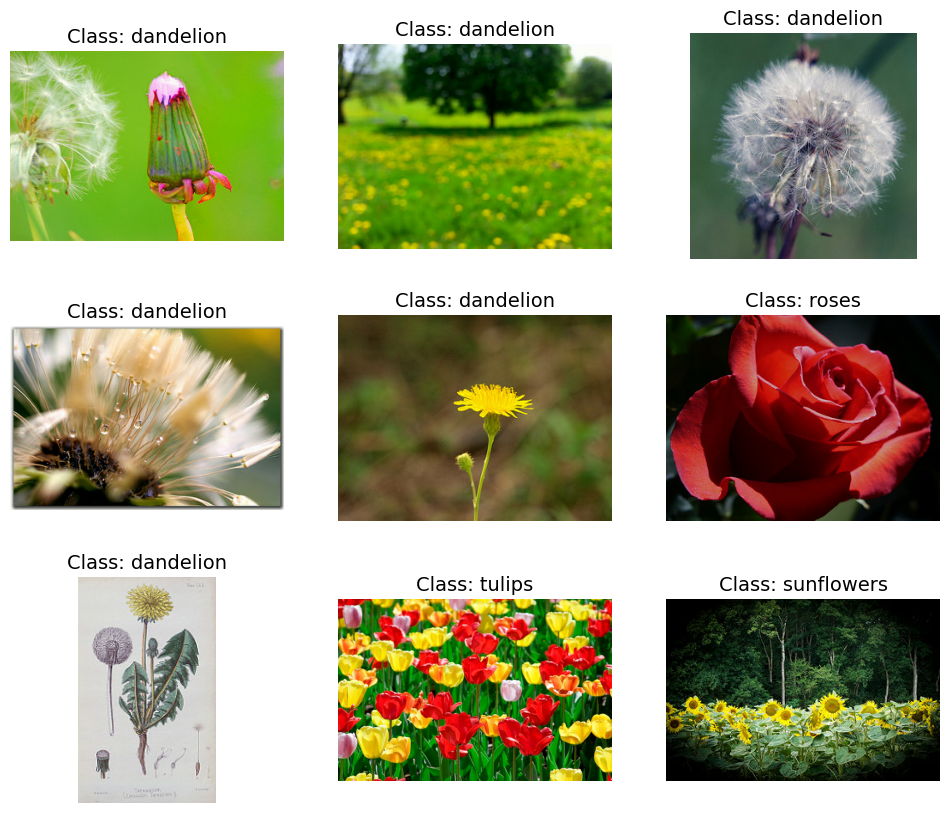

In [54]:
plt.figure(figsize=(12, 10))
index = 0
for image, label in valid_set_raw.take(9):
    index += 1
    plt.subplot(3, 3, index)
    plt.imshow(image)
    plt.title(f"Class: {class_names[label]}")
    plt.axis("off")

plt.show()

In [55]:
tf.keras.backend.clear_session()  # extra code – resets layer name counter

batch_size = 32
preprocess = tf.keras.Sequential([
    tf.keras.layers.Resizing(height=224, width=224, crop_to_aspect_ratio=True),
    tf.keras.layers.Lambda(tf.keras.applications.xception.preprocess_input)
])
train_set = train_set_raw.map(lambda X, y: (preprocess(X), y))
train_set = train_set.shuffle(1000, seed=42).batch(batch_size).prefetch(1)
valid_set = valid_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)
test_set = test_set_raw.map(lambda X, y: (preprocess(X), y)).batch(batch_size)

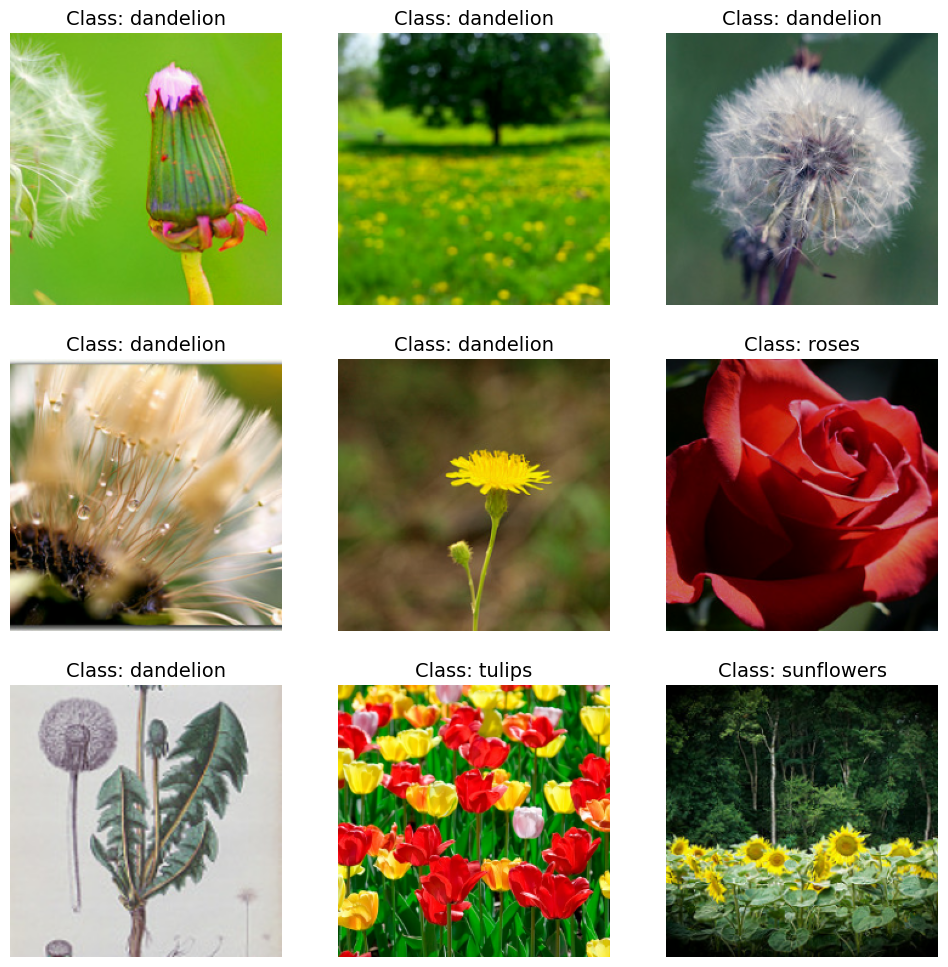

In [56]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        plt.imshow((X_batch[index] + 1) / 2)  # rescale to 0–1 for imshow()
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [57]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip(mode="horizontal", seed=42),
    tf.keras.layers.RandomRotation(factor=0.05, seed=42),
    tf.keras.layers.RandomContrast(factor=0.2, seed=42)
])

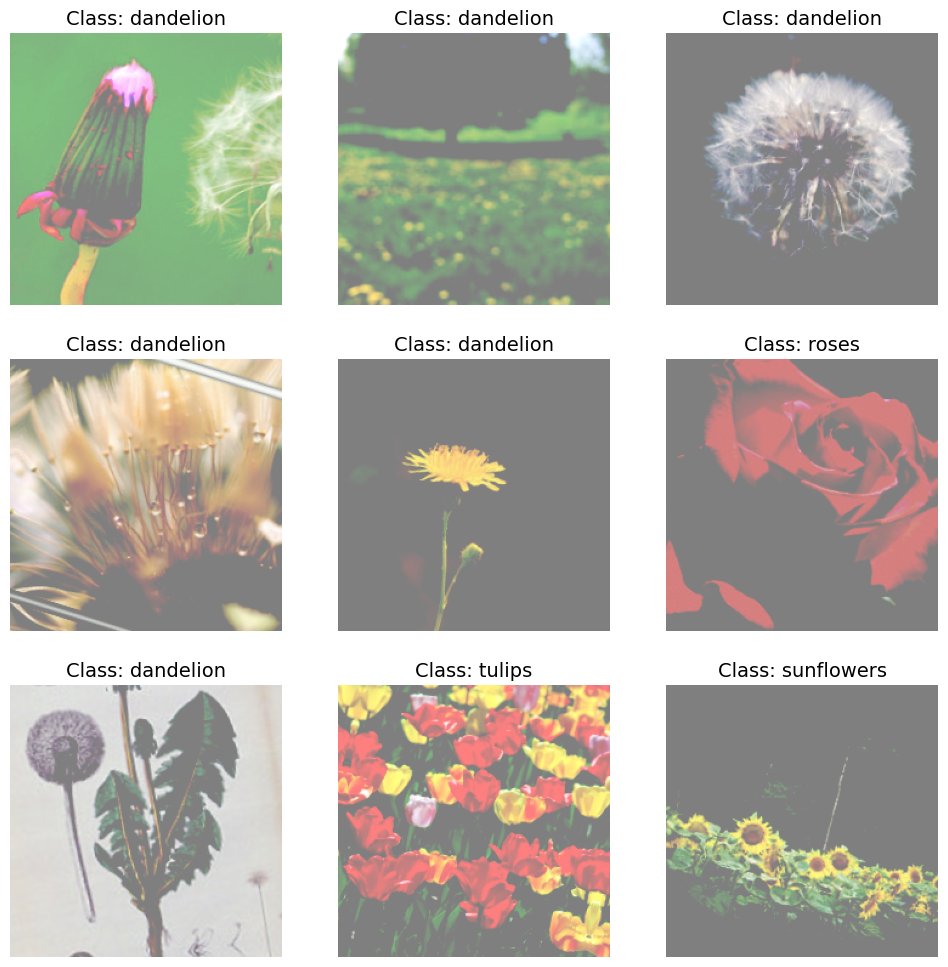

In [58]:
plt.figure(figsize=(12, 12))
for X_batch, y_batch in valid_set.take(1):
    X_batch_augmented = data_augmentation(X_batch, training=True)
    for index in range(9):
        plt.subplot(3, 3, index + 1)
        # We must rescale the images to the 0-1 range for imshow(), and also
        # clip the result to that range, because data augmentation may
        # make some values go out of bounds (e.g., RandomContrast in this case).
        plt.imshow(np.clip((X_batch_augmented[index] + 1) / 2, 0, 1))
        plt.title(f"Class: {class_names[y_batch[index]]}")
        plt.axis("off")

plt.show()

In [59]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
model = tf.keras.Model(inputs=base_model.input, outputs=output)

83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 21s 0us/step


In [60]:
for layer in base_model.layers:
    layer.trainable = False

In [61]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=3)

Epoch 1/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.8052 - loss: 0.8025 - val_accuracy: 0.8475 - val_loss: 0.7060
Epoch 2/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 154s 2s/step - accuracy: 0.9052 - loss: 0.3610 - val_accuracy: 0.8439 - val_loss: 0.6885
Epoch 3/3
86/86 ━━━━━━━━━━━━━━━━━━━━ 147s 2s/step - accuracy: 0.9411 - loss: 0.1879 - val_accuracy: 0.8584 - val_loss: 0.6331


In [62]:
for indices in zip(range(33), range(33, 66), range(66, 99), range(99, 132)):
    for idx in indices:
        print(f"{idx:3}: {base_model.layers[idx].name:22}", end="")
    print()

  0: input_layer_2          33: block4_pool            66: block8_sepconv1_act    99: block11_sepconv2_act  
  1: block1_conv1           34: batch_normalization_2  67: block8_sepconv1       100: block11_sepconv2      
  2: block1_conv1_bn        35: add_2                  68: block8_sepconv1_bn    101: block11_sepconv2_bn   
  3: block1_conv1_act       36: block5_sepconv1_act    69: block8_sepconv2_act   102: block11_sepconv3_act  
  4: block1_conv2           37: block5_sepconv1        70: block8_sepconv2       103: block11_sepconv3      
  5: block1_conv2_bn        38: block5_sepconv1_bn     71: block8_sepconv2_bn    104: block11_sepconv3_bn   
  6: block1_conv2_act       39: block5_sepconv2_act    72: block8_sepconv3_act   105: add_9                 
  7: block2_sepconv1        40: block5_sepconv2        73: block8_sepconv3       106: block12_sepconv1_act  
  8: block2_sepconv1_bn     41: block5_sepconv2_bn     74: block8_sepconv3_bn    107: block12_sepconv1      
  9: block2_sepconv

In [63]:
for layer in base_model.layers[56:]:
    layer.trainable = True

optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model.fit(train_set, validation_data=valid_set, epochs=10)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 425s 5s/step - accuracy: 0.9037 - loss: 0.2882 - val_accuracy: 0.8784 - val_loss: 0.5515
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 411s 5s/step - accuracy: 0.9840 - loss: 0.0543 - val_accuracy: 0.9093 - val_loss: 0.3762
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 394s 5s/step - accuracy: 0.9945 - loss: 0.0158 - val_accuracy: 0.9074 - val_loss: 0.4302
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.9960 - loss: 0.0121 - val_accuracy: 0.9238 - val_loss: 0.3097
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 394s 5s/step - accuracy: 0.9967 - loss: 0.0089 - val_accuracy: 0.9111 - val_loss: 0.3202
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 372s 4s/step - accuracy: 0.9975 - loss: 0.0064 - val_accuracy: 0.9183 - val_loss: 0.3078
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 357s 4s/step - accuracy: 0.9985 - loss: 0.0035 - val_accuracy: 0.9201 - val_loss: 0.3217
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 410s 5s/step - accuracy: 0.9989 - loss: 0.0028 - val_accuracy: 0.9220 - v

In [64]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
base_model = tf.keras.applications.xception.Xception(weights="imagenet",
                                                     include_top=False)
avg = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
class_output = tf.keras.layers.Dense(n_classes, activation="softmax")(avg)
loc_output = tf.keras.layers.Dense(4)(avg)
model = tf.keras.Model(inputs=base_model.input,
                       outputs=[class_output, loc_output])
optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)  # added this line
model.compile(loss=["sparse_categorical_crossentropy", "mse"],
              loss_weights=[0.8, 0.2],  # depends on what you care most about
              optimizer=optimizer, metrics=["accuracy", "mse"])

In [65]:
def add_random_bounding_boxes(images, labels):
    fake_bboxes = tf.random.uniform([tf.shape(images)[0], 4])
    return images, (labels, fake_bboxes)

fake_train_set = train_set.take(5).repeat(2).map(add_random_bounding_boxes)
model.fit(fake_train_set, epochs=2)

Epoch 1/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 100s 8s/step - dense_1_accuracy: 0.3562 - dense_1_loss: 1.5035 - dense_2_loss: 0.3089 - dense_2_mse: 0.3089 - loss: 1.2646
Epoch 2/2
10/10 ━━━━━━━━━━━━━━━━━━━━ 86s 8s/step - dense_1_accuracy: 0.6656 - dense_1_loss: 1.0351 - dense_2_loss: 0.2107 - dense_2_mse: 0.2107 - loss: 0.8702
